In [40]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [5]:
# read images from directory as tensors
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    # specify the directory that contains the images
    'PlantVillage',
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


2024-07-29 16:11:10.317802: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-07-29 16:11:10.317821: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-07-29 16:11:10.317829: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-07-29 16:11:10.317995: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-29 16:11:10.318019: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
# get the class name form tenser dataset (subdirectories) in the directory (PlantVillage)
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
# the length of the dataset is the number of batches with the specified batch size (32)
len(dataset)

68

In [8]:
len(dataset)*BATCH_SIZE

2176

2024-07-29 16:19:44.608863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


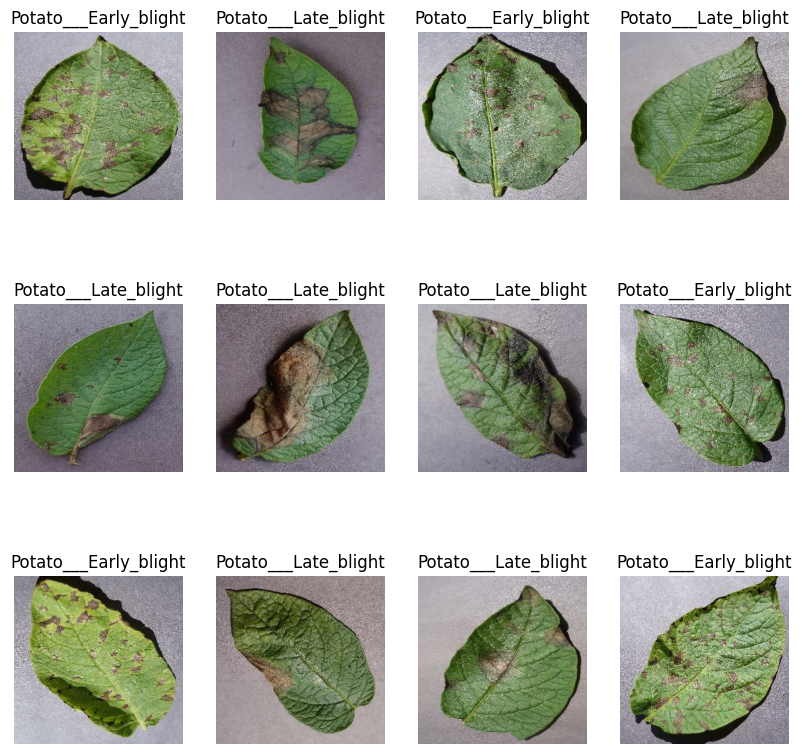

In [19]:
# show the first 12 images and their labels from the dataset
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [30]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * len(ds))
    val_size = int(val_split * len(ds))
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [31]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [32]:
len(train_ds)

54

In [34]:
len(val_ds)

6

In [35]:
len(test_ds)

8

In [36]:
# cache, shuffle, and prefetch the dataset for better performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [45]:
# creating the layers of the preprocessing 

# Build the rescaling and resizing layer for the model to ensure the input images are of the same size
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

# Build data augmentation layer to prevent overfitting
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])